In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib

In [4]:
# Load the dataset
df = pd.read_csv("/home/hgidea/Desktop/Coding/Python/hackthon/intel/archive/global air pollution dataset.csv")

# Verify the columns
print("Initial Columns:", df.columns)

Initial Columns: Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category'],
      dtype='object')


In [5]:
# Drop missing values
df = df.dropna()

In [6]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:

# Select only numeric columns for correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

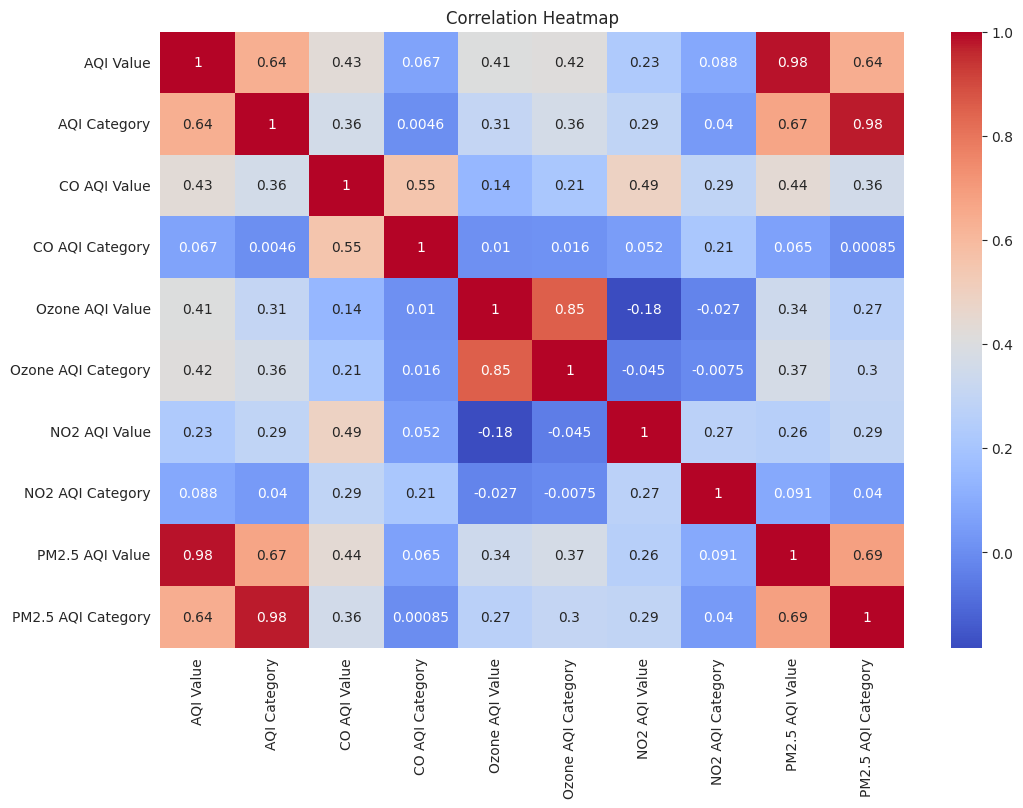

In [8]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [9]:
# Split data into features and target
features_to_use = ['PM2.5 AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value',
                   'AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']
X = df[features_to_use]
y = df['AQI Value']

In [10]:
# Create a pipeline for preprocessing
numeric_features = ['PM2.5 AQI Value', 'Ozone AQI Value', 'CO AQI Value', 'NO2 AQI Value']
categorical_features = ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']


In [11]:

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])


In [12]:
# Apply the preprocessor to the features
X_processed = preprocessor.fit_transform(X)

In [13]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



In [14]:
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

Mean Squared Error: 9.131835359235945
R-squared: 0.9972596461675365


In [15]:
# GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [16]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [17]:
# Get the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [18]:
# Make predictions
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [19]:

print(f'Best parameters: {best_params}')
print(f'Best Model Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Mean Squared Error: 8.826287648305525
R-squared: 0.997351337356406


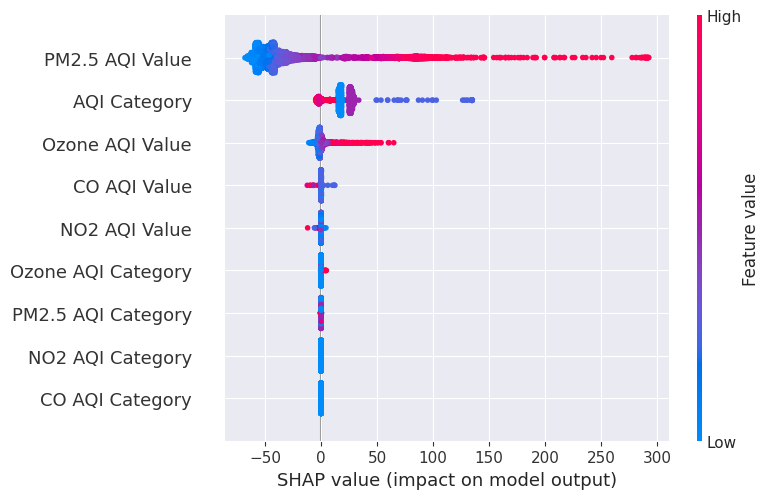

In [20]:
# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=numeric_features + categorical_features)


In [21]:

# Residual Analysis
residuals = y_test - y_pred

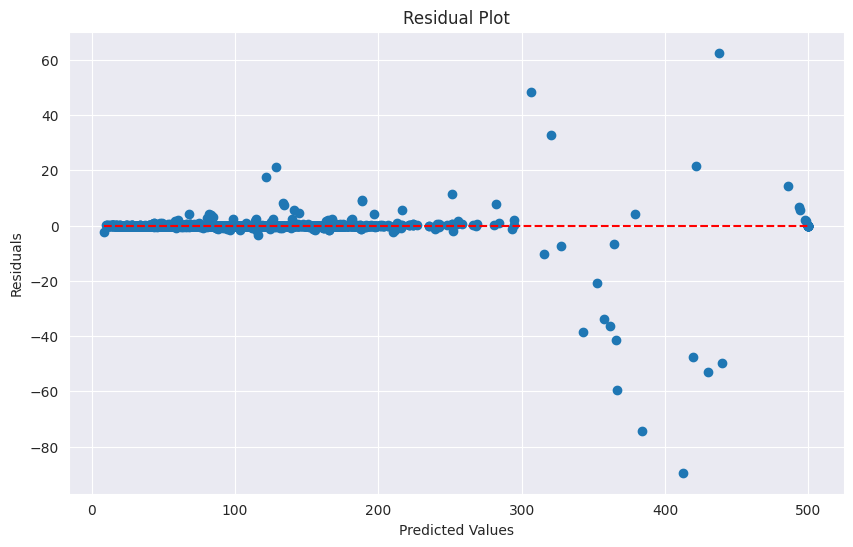

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


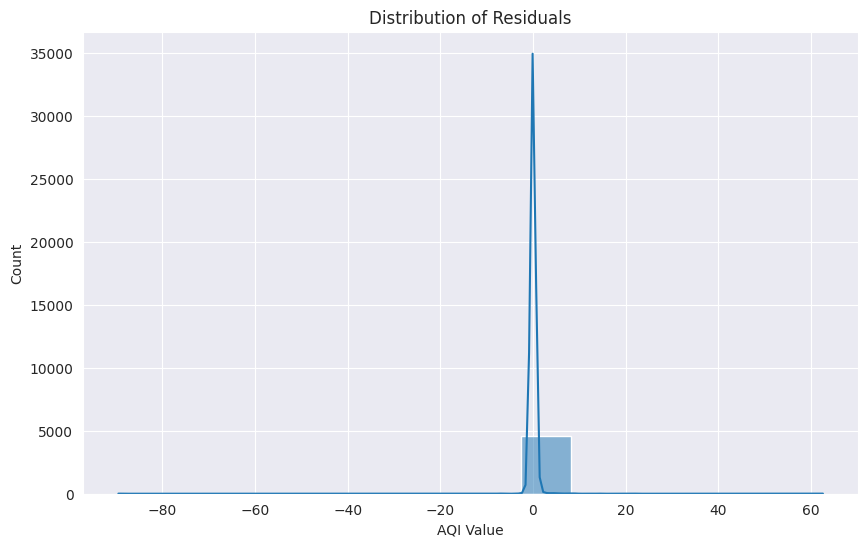

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()


In [24]:
# Save the model
joblib.dump(best_model, '/home/hgidea/Desktop/Coding/Python/hackthon/intel/best_random_forest_model (2).pkl')
    

['/home/hgidea/Desktop/Coding/Python/hackthon/intel/best_random_forest_model (2).pkl']